# Segmentation d'images avec la méthode Watershed 

Dans ce notebook, nous proposons d'appliquer une méthode de segmentation bien connue, basée sur des techniques classiques de traitement d'image plutôt que sur de l'apprentissage automatique. L'objectif est de se familiariser avec le problème de la segmentation d'images et de voir comment ce type de méthode baseline se comportait pour ce problème, avant l'apparition des méthodes d'apprentissage profond.

La méthode que nous allons mettre en œuvre est appelée Watershed (https://en.wikipedia.org/wiki/Watershed_(image_processing)).

## Principe de la segmentation d'image

La segmentation d'une image est le processus qui consiste à diviser une image numérique en plusieurs régions (ensembles de pixels, également connus sous le nom de superpixels). L'objectif est de simplifier et/ou de modifier la représentation d'une image en quelque chose de plus significatif et de plus facile à analyser. La segmentation d'images est généralement utilisée pour localiser des objets et des zones d'intérêt dans des images. Plus précisément, la segmentation d'images consiste à attribuer une étiquette à chaque pixel d'une image de telle sorte que les pixels ayant la même étiquette partagent certaines caractéristiques.

Nous donnons ci-dessous un exemple de segmentation d'images à partir d'un dataset bien connu qui contient des images de portraits de célébrités. L'objectif est ici de séparer les différentes parties du visage dans l'image (yeux, nez, bouche, etc.).

![celebahq.png](./assets/images/celebahq.png)  

*source: https://github.com/tkarras/progressive_growing_of_gans*

Les méthodes à l'état-de-l'art pour ce type de tâches sont aujourd'hui basées sur l'apprentissage profond. Cependant, avant l'apparition de ces méthodes, des techniques plus classiques de traitement d'image étaient le plus souvent utilisées, avec des résultats plus ou moins satisfaisants. L'une de ces méthodes est la méthode des Watersheds, que nous allons présenter dans ce notebook.

## Principe de la méthode Watershed
Pour comprendre le principe de cette méthode, imaginez qu'une image en niveaux de gris est une surface topographique où une forte intensité indique les sommets et les collines, tandis qu'une faible intensité indique les vallées. Imaginons maintenant que nous commencions à remplir toutes les vallées isolées (minima locaux) avec de l'eau de couleur différente (étiquettes). Au fur et à mesure que l'eau monte, en fonction des pics à proximité, les eaux de différentes vallées, de couleurs différentes, commenceront à se mélanger. Pour éviter cela, nous construisons des barrières aux endroits où les eaux se mélangent. Nous continuons à remplir l'eau et à construire des barrières jusqu'à ce que tous les sommets soient immergés. Les barrières que nous avons construites nous donnent alors le résultat de la segmentation.

Cette méthode est connue pour donner des résultats trop fragmentés en présence de bruit ou de fortes irrégularités dans l'image. Elle est généralement plus adaptée à la division des images en régions d'intérêt adjacentes qu'à la détection de formes isolées. Une façon d'atténuer ce problème consiste à utiliser des marqueurs pour guider l'algorithme dans la segmentation de l'image. Ces marqueurs peuvent être obtenus à partir de l'image elle-même ou de sources externes. Dans ce qui suit, nous utiliserons quelques transformations morphologiques de base de l'image pour obtenir les marqueurs, correspondant aux régions des images qui sont susceptibles de contenir des objets.

## Configuration de l'environnement et préparation des données
Pour appliquer la méthode watershed, nous allons nous appuyer sur la bibliothèque python `OpenCV`, une bibliothèque open-source qui contient des implémentations de plusieurs centaines de méthodes de vision par ordinateur. Nous utiliserons également la bibliothèque `matplotlib` pour afficher les images, la bibliothèque `numpy` pour quelques opérations de base en python et la bibliothèque `os` pour accéder aux différents fichiers d'images que nous utiliserons.

In [81]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os

Nous devons maintenant préparer les images que nous voulons segmenter. Dans ce qui suit, nous proposons d'utiliser le dataset EMPS, une collection de 465 images de microscopie électronique et leurs segmentations sémantiques correspondantes au niveau du pixel. (https://github.com/by256/emps). 

Les scripts python suivants nécessitent le téléchargement préalable du jeu de données et l'extraction des images et des masques dans les répertoires `emps/emps-main/images` et `emps/emps-main/segmaps` respectivement.

In [82]:
images_directory = 'emps/emps-main/images/'
masks_directory = 'emps/emps-main/segmaps/'

Nous créons maintenant une liste des fichiers images et masques et nous affichons ensuite une des pairs image/masque pour visualiser un exemple.

In [83]:
def list_files(img_dir, msk_dir):
    """ List images and masks files from the given directories """
    # the os.listdir function lists the files in a directory but does not sort them. Thus, we need to sort the list to have the images and masks in the same order.
    images_list = sorted([os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".png")])
    masks_list = sorted([os.path.join(msk_dir, fname) for fname in os.listdir(msk_dir) if fname.endswith(".png")])
    return images_list, masks_list

# Check that we have the same number of images and masks and that they are sorted in the same order
images_list, masks_list = list_files(images_directory, masks_directory)
print(f"Number of images: {len(images_list)}")
print(images_list[0:5])
print(f"Number of masks: {len(masks_list)}")
print(masks_list[0:5])

Number of images: 465
['emps/emps-main/images/00655d9628.png', 'emps/emps-main/images/0113230c21.png', 'emps/emps-main/images/0144266d21.png', 'emps/emps-main/images/01ac659240.png', 'emps/emps-main/images/027f25010a.png']
Number of masks: 465
['emps/emps-main/segmaps/00655d9628.png', 'emps/emps-main/segmaps/0113230c21.png', 'emps/emps-main/segmaps/0144266d21.png', 'emps/emps-main/segmaps/01ac659240.png', 'emps/emps-main/segmaps/027f25010a.png']


(512, 512, 3)


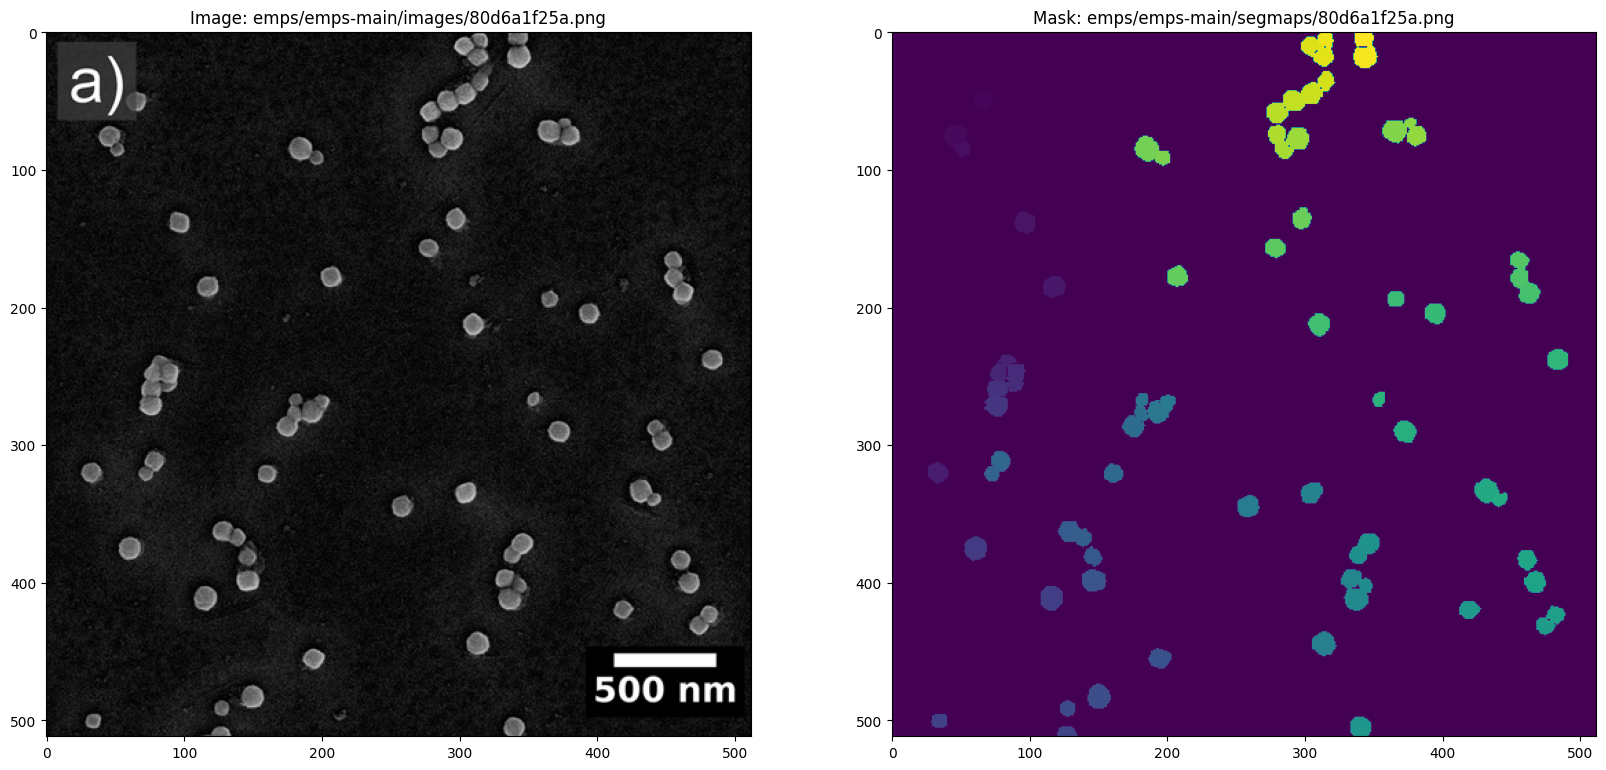

In [84]:
def list_to_arrays(img_list, msk_list):
    """Load images and masks from the given lists and return them as arrays"""
    images = [cv.imread(image, cv.IMREAD_UNCHANGED) for image in img_list]
    masks = [cv.imread(mask, cv.IMREAD_UNCHANGED) for mask in msk_list]
    return images, masks

images, masks = list_to_arrays(images_list, masks_list)
idx = 222 # let's take the 222th image (almost at random)
print(images[idx].shape)
# print(images[idx]) # uncomment to see the pixel values

# Display the image and the mask using matplotlib
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[idx])
plt.title(f"Image: {images_list[idx]}")
plt.subplot(1, 2, 2)
plt.imshow(masks[idx])
plt.title(f"Mask: {masks_list[idx]}")
plt.show()

Le masque ci-dessus est le résultat que nous visons avec la méthode Watershed. Pour ce faire, nous devons d'abord appliquer des opérations morphologiques à l'image afin d'en déduire des marqueurs qui serviront à guider l'algorithme. La première de ces opérations est une binarisation de l'image pour obtenir une approximation des formes que nous voulons segmenter. Cette binarisation est obtenue ici à l'aide de la méthode Otsu, qui calcule automatiquement un seuil de binarisation adapté.

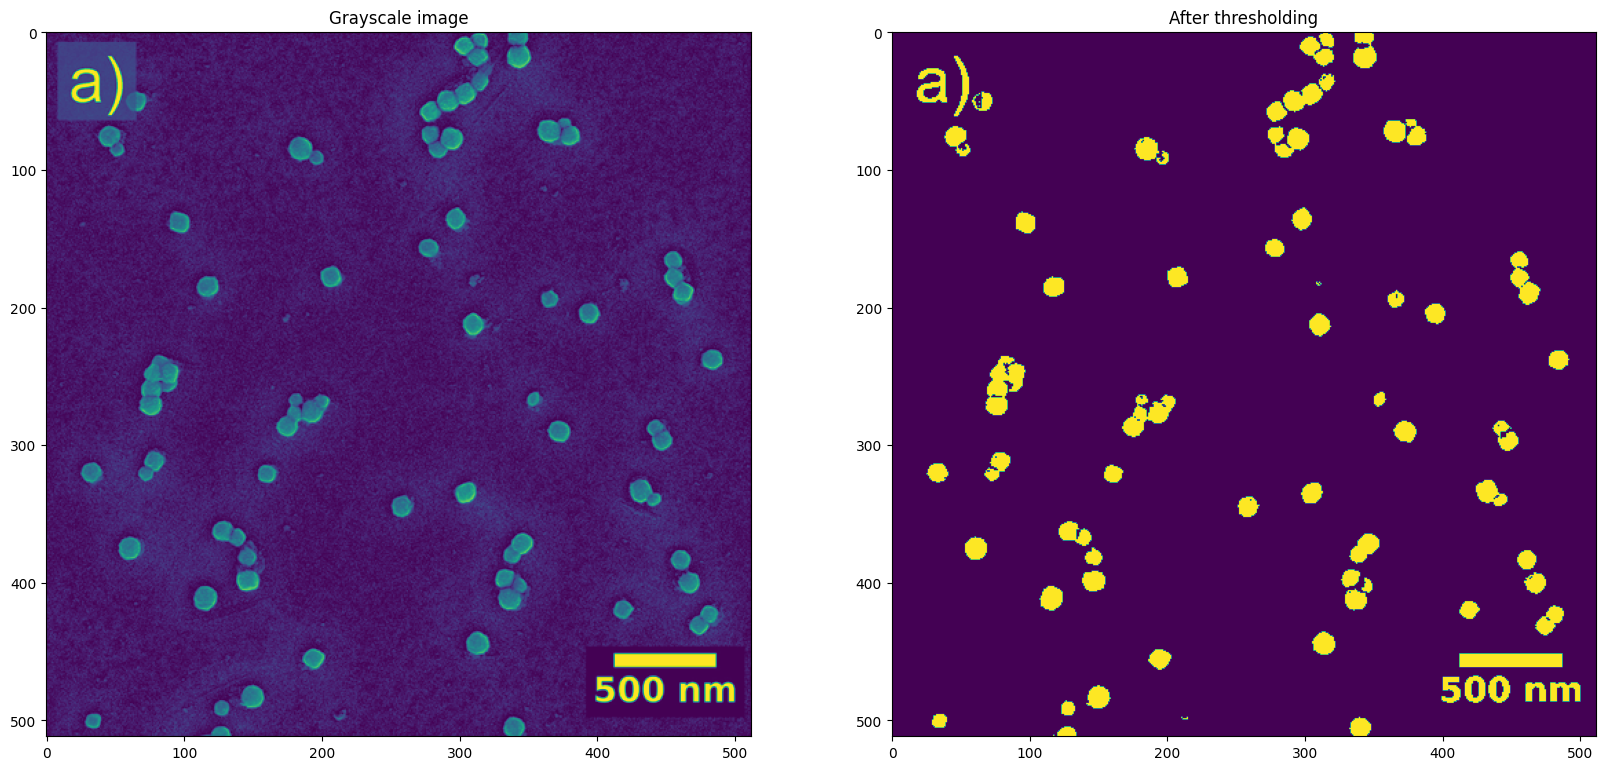

In [85]:
def otsu_binarization(img):
    # Image binarization by converting to grayscale and applying Otsu's' thresholding
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return gray, thresh

gray, thresh = otsu_binarization(images[idx])

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray)
plt.title("Grayscale image")
plt.subplot(1, 2, 2)
plt.imshow(thresh)
plt.title("After thresholding")
plt.show()

La binarisation de l'image nous permet de séparer l'arrière-plan du premier plan. Cependant, l'image binarisée contient du bruit que nous devons éliminer avant d'appliquer la méthode Watershed. Cette élimination du bruit se fait en appliquant des opérations morphologiques à l'image binarisée. La première opération est une ouverture, qui supprime le bruit « blanc » dans les régions d'arrière-plan. Elle consiste à éroder l'image (éroder les limites des objets de premier plan) puis à la dilater (ajouter des pixels aux limites des objets de premier plan). La seconde opération est une fermeture, l'opération miroir de l'ouverture, qui supprime le bruit « noir » dans l'objet de premier plan.

Cette étape de suppression du bruit est suivie d'une opération de dilatation supplémentaire, de sorte que toutes les régions d'arrière-plan restantes sont considérées comme des régions d'arrière-plan « sûres ».

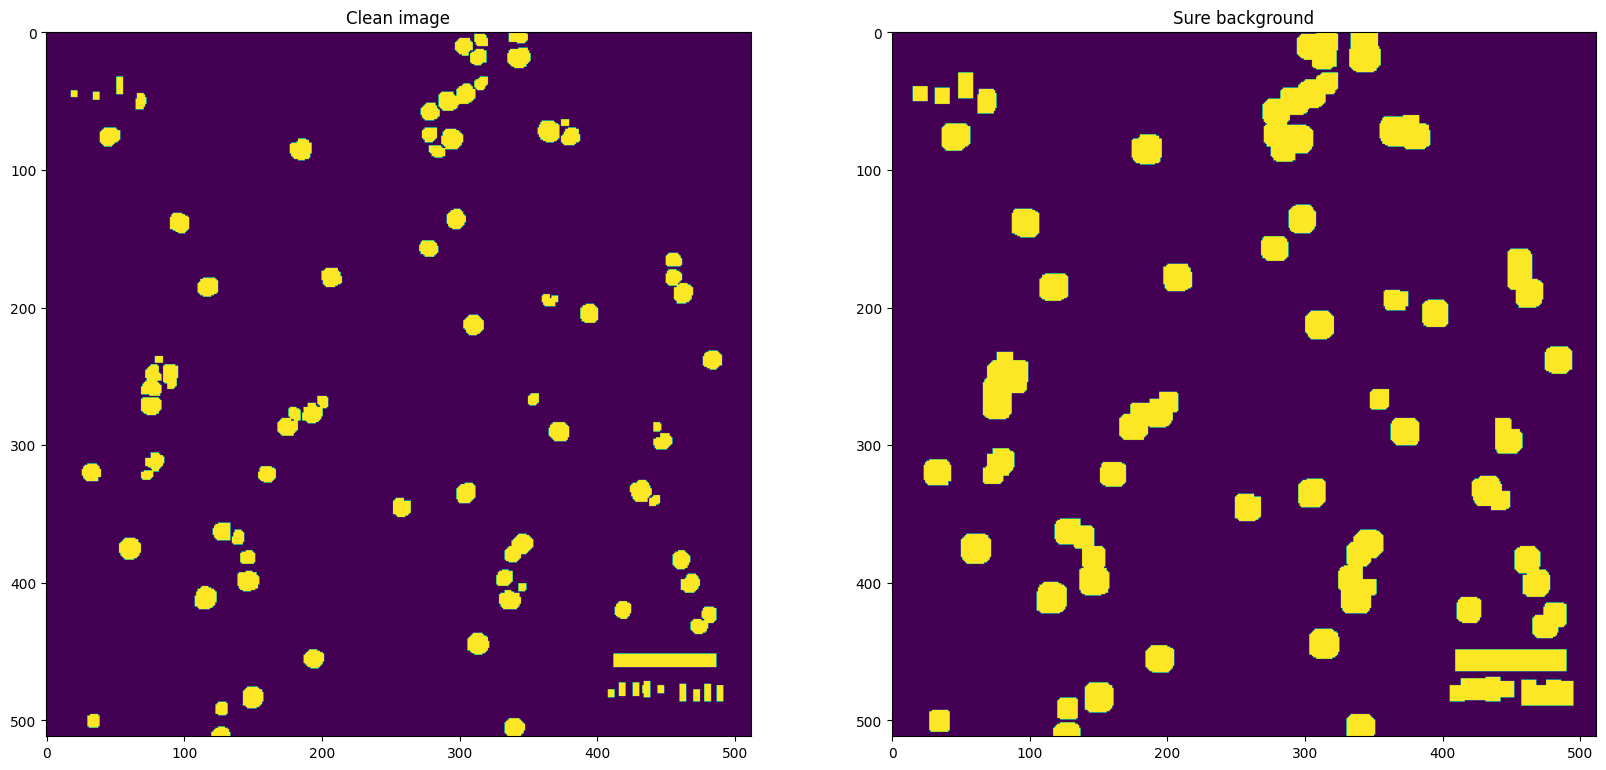

In [86]:
def noise_removal(binarized_image):
    # noise removal: 'white' noise in background regions are removed by opening and 'black' noise in foreground object are removed by closing 
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(binarized_image, cv.MORPH_OPEN, kernel, iterations=2)
    clean = cv.morphologyEx(opening, cv.MORPH_OPEN, kernel, iterations=2)
    return clean

def sure_background(clean):
    # detect regions of the images that are 'sure' background after an additional dilatation operation
    kernel = np.ones((3,3),np.uint8)
    sure_bg = cv.dilate(clean, kernel, iterations=3)
    return sure_bg

clean = noise_removal(thresh)
sure_bg = sure_background(clean)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(clean)
plt.title("Clean image")
plt.subplot(1, 2, 2)
plt.imshow(sure_bg)
plt.title("Sure background")
plt.show()

Toutes les parties sombres de l'image *Sure background* peuvent maintenant être utilisées comme marqueurs pour les régions de l'image dont nous sommes sûrs qu'elles appartiennent à l'arrière-plan. L'étape suivante consiste à faire de même pour les régions dont nous sommes sûrs qu'elles appartiennent à des objets de premier plan. Pour ce faire, nous utiliserons la transformée de distance qui donne à chaque pixel une valeur de niveau de gris correspondant à la distance avec le pixel d'arrière-plan le plus proche. Les régions qui sont « certainement » des objets de premier plan peuvent alors être obtenues par seuillage de cette transformée de distance.

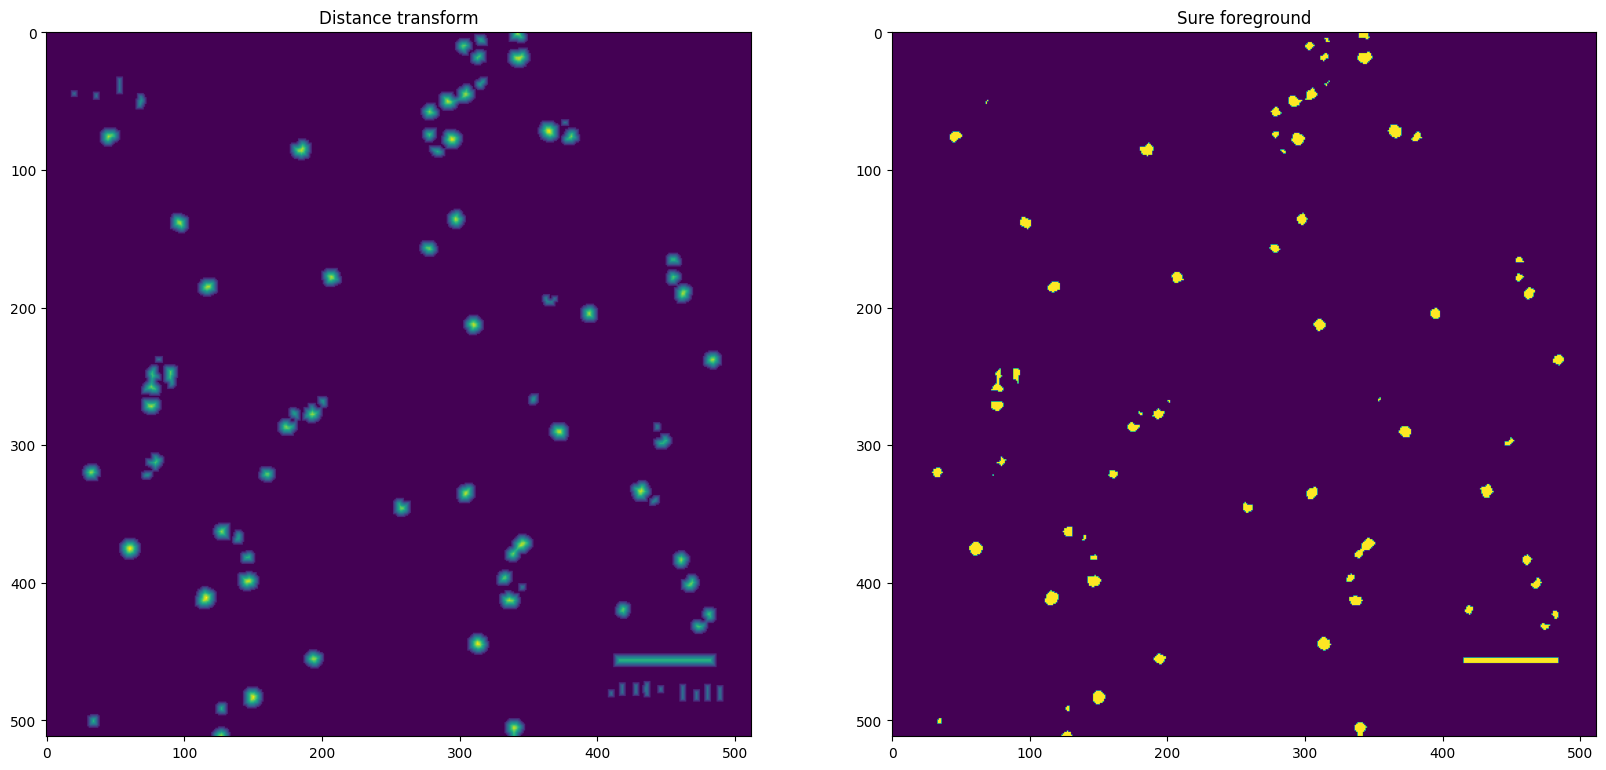

In [87]:
def sure_foreground(opening, lam=0.5):
    # detect regions of the images that are 'sure' foreground by distance transform and thresholding
    # Note: the 'lam' parameter is used to adjust the threshold value (instead of using Otsu's method)
    #       lam=0.5 means that the threshold is set to 50% of the maximum distance transform value
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    _, sure_fg = cv.threshold(dist_transform, lam * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    return dist_transform, sure_fg

dist_transform, sure_fg = sure_foreground(clean)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(dist_transform)
plt.title("Distance transform")
plt.subplot(1, 2, 2)
plt.imshow(sure_fg)
plt.title("Sure foreground")
plt.show()

Maintenant que nous disposons des marqueurs de premier plan et d'arrière-plan sûrs, nous pouvons appliquer l'algorithme Watershed pour segmenter l'image et identifier les formes, en mettant en évidence leurs contours. Le tableau de marqueurs qui doit être donné en entrée à l'implémentation utilisée ci-dessous, contient des 0 pour chaque pixel appartenant aux régions inconnues, des 1 pour les pixels appartenant à l'arrière-plan et différentes valeurs entières supérieures à 1 pour les pixels appartenant à l'avant-plan.

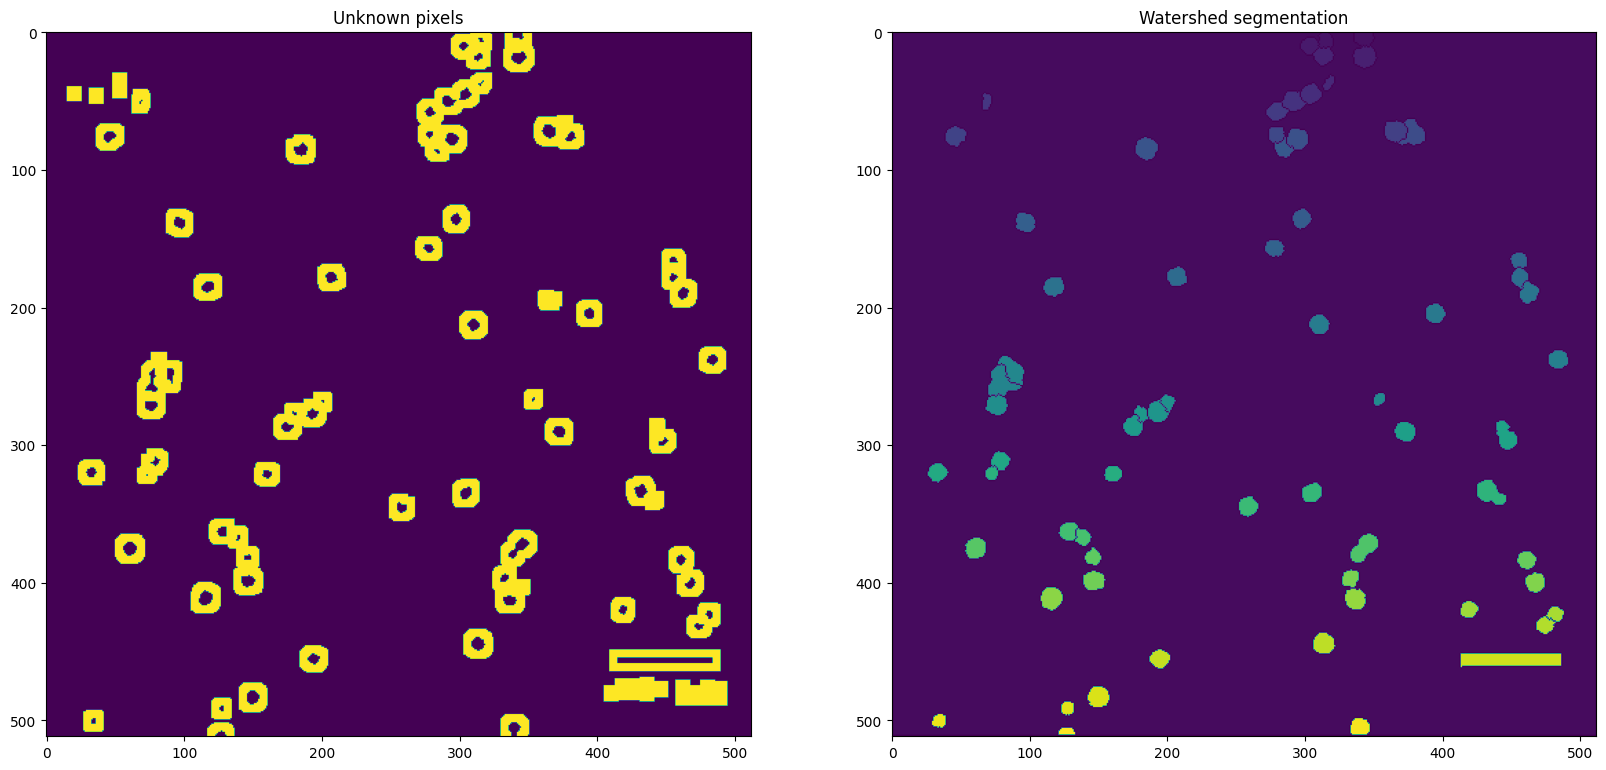

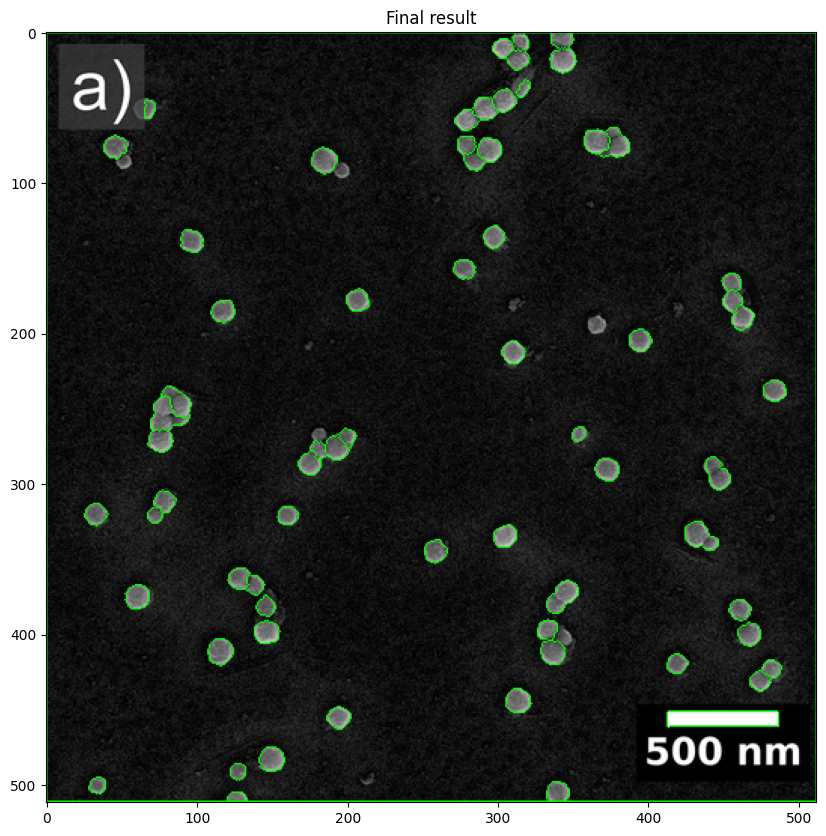

In [88]:
def watershed(image, sure_fg, sure_bg):
    unknown = cv.subtract(sure_bg, sure_fg)
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = cv.watershed(image, markers)
    image[markers == -1] = [0, 255, 0] # mark the contours in green
    return image, markers, unknown

img_w, markers, unknown = watershed(images[idx], sure_fg, sure_bg)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(unknown)
plt.title("Unknown pixels")
plt.subplot(1, 2, 2)
plt.imshow(markers)
plt.title("Watershed segmentation")
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(img_w)
plt.title("Final result")
plt.show()

## Plus de tests avec la méthode Watershed

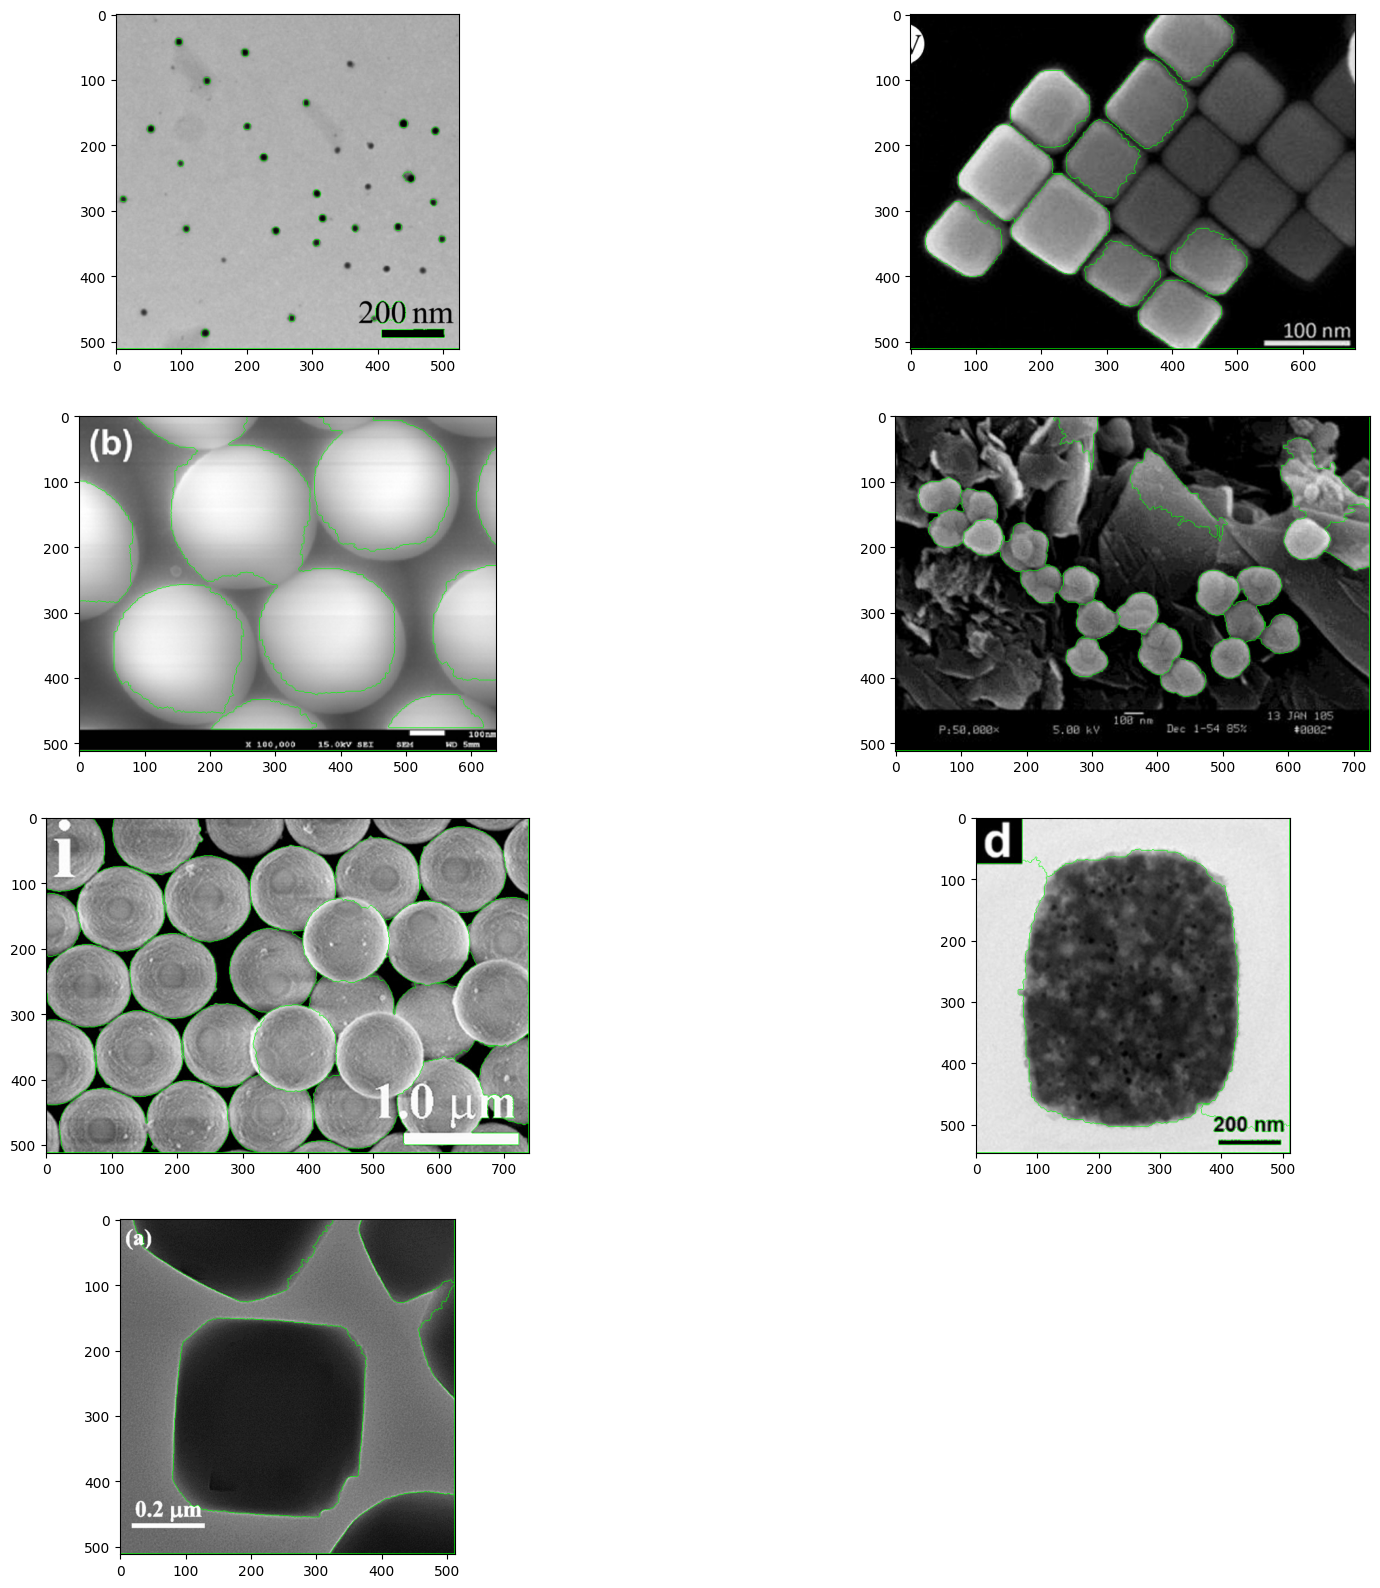

In [89]:
def watershed_pipeline(image, lam=0.5):
    gray, thresh = otsu_binarization(image)
    clean = noise_removal(thresh)
    sure_bg = sure_background(clean)
    dist_transform, sure_fg = sure_foreground(clean, lam)
    img_w, markers, unknown = watershed(image, sure_fg, sure_bg)
    return img_w

exple1 = watershed_pipeline(images[11], lam=0.8)
exple2 = watershed_pipeline(images[33], lam=0.6)
exple3 = watershed_pipeline(images[42], lam=0.07)
exple4 = watershed_pipeline(images[112])
exple5 = watershed_pipeline(images[366])
exple6 = watershed_pipeline(images[404], lam=0.2)
exple7 = watershed_pipeline(images[111], lam=0.1)

plt.figure(figsize=(20, 20))
plt.subplot(4, 2, 1)
plt.imshow(exple1)
plt.subplot(4, 2, 2)
plt.imshow(exple2)
plt.subplot(4, 2, 3)
plt.imshow(exple3)
plt.subplot(4, 2, 4)
plt.imshow(exple4)
plt.subplot(4, 2, 5)
plt.imshow(exple5)
plt.subplot(4, 2, 6)
plt.imshow(exple6)
plt.subplot(4, 2, 7)
plt.imshow(exple7)
plt.show()

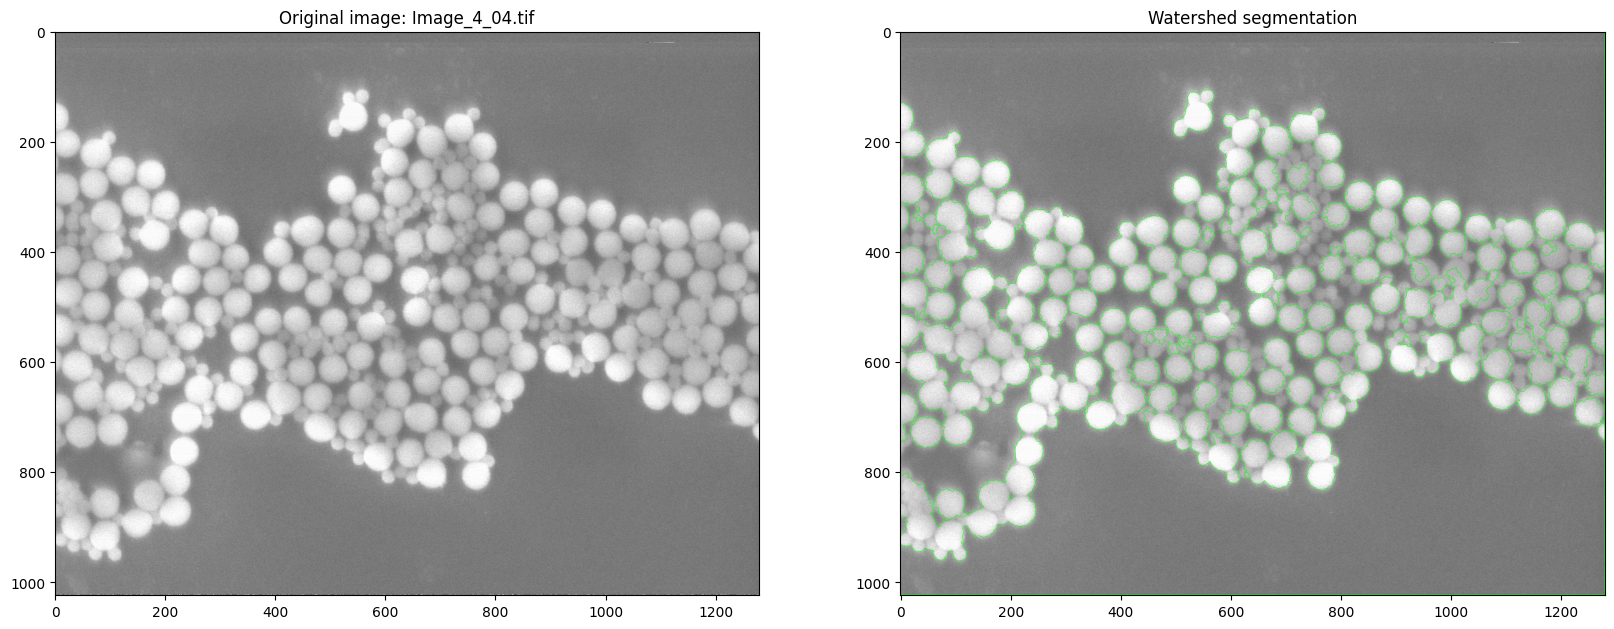

In [90]:
folder_name = './images_raw/CEA2_MEB'
image_name = "Image_4_04.tif"
image_path = os.path.join(folder_name, image_name)
image = cv.imread(image_path, cv.IMREAD_UNCHANGED)  
if len(image.shape) == 2: # Convert image to RGB if it is in grayscale
    image = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
image_seg = watershed_pipeline(image.copy(), lam=0.2) # Note: work on a copy of the image to avoid modifying the original image

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Original image: {image_name}")
plt.subplot(1, 2, 2)
plt.imshow(image_seg)
plt.title(f"Watershed segmentation")
plt.show()